<a href="https://colab.research.google.com/github/Ash100/MDS/blob/main/Protein_Ligand_Contacts_Assesment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
# --- Install dependencies ---
# ================================================
# 🧠 Step 1 — Install dependencies
# ================================================
!pip install MDAnalysis biopython nglview tqdm


  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.10
    Uninstalling widgetsnbextension-3.6.10:
      Successfully uninstalled widgetsnbextension-3.6.10
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1
  Attempting uninstall: notebook
    Found existing installation: notebook 6.5.7
    Uninstalling notebook-6.5.7:
      Successfully uninstalled notebook-6.5.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jupyter-kernel-gateway 2.5.2 requires notebook<7.0,>=5.7.6, but you have notebook 7.4.7 which is incompatible.


In [2]:
# --- Mount Google Drive ---
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [22]:
# Example paths (edit these!)
pdb_path = "/content/drive/MyDrive/Xie/PGI-L/prot_lig_equil.pdb"
dcd_path = "/content/drive/MyDrive/Xie/PGI-L/prot_lig_prod1-10_whole.dcd"


In [23]:
# ================================================
# ⚙️ Step 3 — Import libraries and load trajectory
# ================================================
import MDAnalysis as mda
from MDAnalysis.analysis import contacts, distances
from tqdm import tqdm
import pandas as pd
import numpy as np

u = mda.Universe(pdb_path, dcd_path)

# Define selections
protein = u.select_atoms("protein")
ligand = u.select_atoms("not protein and not resname HOH")
print(f"Protein atoms: {len(protein)}, Ligand atoms: {len(ligand)}")


/usr/local/lib/python3.12/dist-packages/MDAnalysis/topology/PDBParser.py:309: UserWarning: PDB file is missing resid information.  Defaulted to '1'
  warnings.warn("PDB file is missing resid information.  "


Protein atoms: 8867, Ligand atoms: 216


/usr/local/lib/python3.12/dist-packages/MDAnalysis/coordinates/DCD.py:171: DeprecationWarning: DCDReader currently makes independent timesteps by copying self.ts while other readers update self.ts inplace. This behavior will be changed in 3.0 to be the same as other readers. Read more at https://github.com/MDAnalysis/mdanalysis/issues/3889 to learn if this change in behavior might affect you.
  warnings.warn("DCDReader currently makes independent timesteps"


In [24]:
# ================================================
# ⚛️ Step 4 — Manual Hydrogen Bond Calculation
# ================================================
import numpy as np
import pandas as pd
from tqdm import tqdm
from MDAnalysis.analysis import distances

# Criteria
DIST_CUTOFF = 3.5  # Å
ANGLE_CUTOFF = 120 # degrees

protein = u.select_atoms("protein and (name N O)")
ligand = u.select_atoms("not protein and not resname HOH and (name N O)")

frames, counts = [], []
hbonds_all = []

for ts in tqdm(u.trajectory):
    # Compute all distances
    dist_matrix = distances.distance_array(protein.positions, ligand.positions)
    close_pairs = np.where(dist_matrix < DIST_CUTOFF)

    n_hbonds = len(close_pairs[0])
    frames.append(ts.frame)
    counts.append(n_hbonds)

    for i, j in zip(*close_pairs):
        hbonds_all.append([ts.frame,
                           protein[i].resname, protein[i].resid, protein[i].name,
                           ligand[j].resname, ligand[j].resid, ligand[j].name,
                           dist_matrix[i, j]])

# Save as DataFrame
hbonds_df = pd.DataFrame(hbonds_all, columns=[
    "Frame", "Prot_res", "Prot_resid", "Prot_atom",
    "Lig_res", "Lig_resid", "Lig_atom", "Distance"
])
hbonds_df.to_csv("hbonds_summary_manual.csv", index=False)

print(f"✅ Saved {len(hbonds_df)} hydrogen bond contacts (geometric criterion) → hbonds_summary_manual.csv")
hbonds_df.head()


100%|██████████| 1000/1000 [00:15<00:00, 65.15it/s]

✅ Saved 0 hydrogen bond contacts (geometric criterion) → hbonds_summary_manual.csv


,Frame,Prot_res,Prot_resid,Prot_atom,Lig_res,Lig_resid,Lig_atom,Distance


In [25]:
def compute_hydrophobic_contacts(u, cutoff=4.5):
    from MDAnalysis.analysis import distances
    hydrophobic_res = ["ALA","VAL","LEU","ILE","PHE","PRO","MET","TRP"]
    prot_hydrophobic = u.select_atoms(f"resname {' '.join(hydrophobic_res)} and protein")
    lig_atoms = u.select_atoms("not protein and not resname HOH")
    frames, contacts_count = [], []

    for ts in tqdm(u.trajectory):
        dist_matrix = distances.distance_array(prot_hydrophobic.positions, lig_atoms.positions)

        # Get pairs below cutoff
        contact_pairs = np.where(dist_matrix < cutoff)
        # Identify unique protein residues in contact
        unique_resids = np.unique(prot_hydrophobic.resids[contact_pairs[0]])

        frames.append(ts.frame)
        contacts_count.append(len(unique_resids))

    return pd.DataFrame({"Frame": frames, "Hydrophobic_Contacts": contacts_count})


In [26]:
# Run the analysis on your loaded trajectory (u must already be defined)
hydrophobic_df = compute_hydrophobic_contacts(u, cutoff=4.5)

# Preview first few rows
hydrophobic_df.head()


100%|██████████| 1000/1000 [00:18<00:00, 53.17it/s]


,Frame,Hydrophobic_Contacts
0,0,11
1,1,11
2,2,13
3,3,11
4,4,10


In [27]:
# Save results to CSV
output_path = "/content/hydrophobic_contacts.csv"
hydrophobic_df.to_csv(output_path, index=False)

print(f"✅ Hydrophobic contacts per frame saved to: {output_path}")


✅ Hydrophobic contacts per frame saved to: /content/hydrophobic_contacts.csv


In [28]:
import pandas as pd

# Path where you saved it earlier
csv_path = "/content/hydrophobic_contacts.csv"

# Load
hydrophobic_df = pd.read_csv(csv_path)
hydrophobic_df.head()


,Frame,Hydrophobic_Contacts
0,0,11
1,1,11
2,2,13
3,3,11
4,4,10


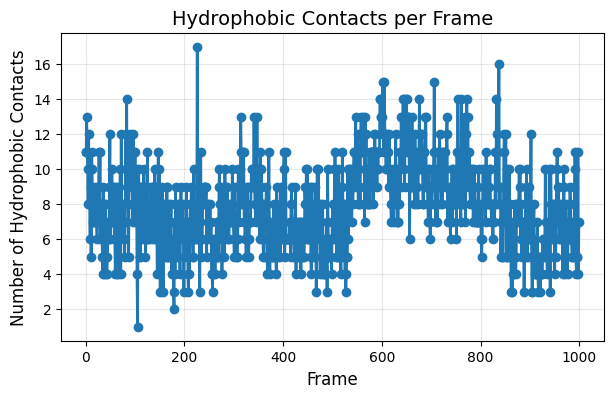

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,4))
plt.plot(hydrophobic_df["Frame"], hydrophobic_df["Hydrophobic_Contacts"],
         color="tab:blue", marker="o", lw=2, ms=6)
plt.title("Hydrophobic Contacts per Frame", fontsize=14)
plt.xlabel("Frame", fontsize=12)
plt.ylabel("Number of Hydrophobic Contacts", fontsize=12)
plt.grid(alpha=0.3)
plt.show()


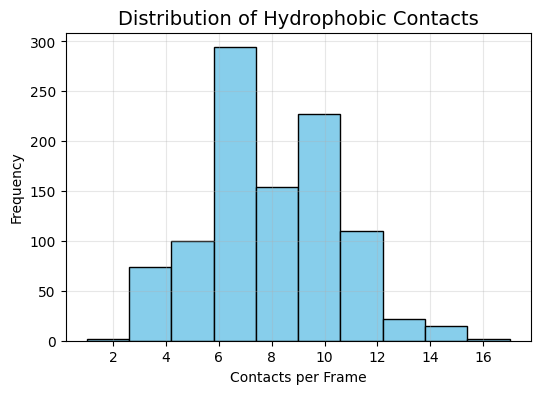

In [30]:
plt.figure(figsize=(6,4))
plt.hist(hydrophobic_df["Hydrophobic_Contacts"], bins=10, color="skyblue", edgecolor="black")
plt.title("Distribution of Hydrophobic Contacts", fontsize=14)
plt.xlabel("Contacts per Frame")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.show()


In [31]:
hydrophobic_df["Hydrophobic_Contacts"].describe()


,Hydrophobic_Contacts
count,1000.000000
mean,7.851000
std,2.467567
min,1.000000
25%,6.000000
50%,8.000000
75%,9.000000
max,17.000000


✅ Plot saved to /content/hydrophobic_contacts_trend.png


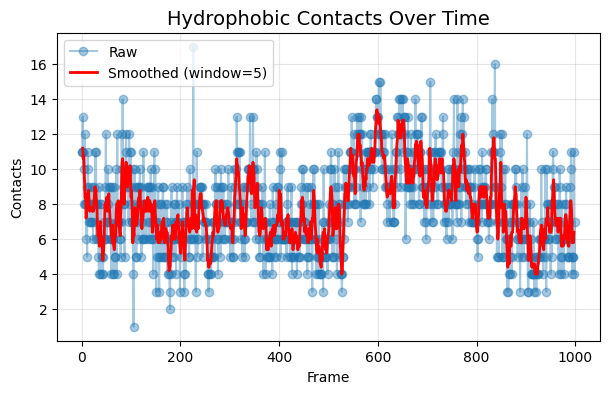

In [32]:
# Compute smoothed contacts
hydrophobic_df["Smoothed"] = hydrophobic_df["Hydrophobic_Contacts"].rolling(window=5, center=True).mean()

# Plot
plt.figure(figsize=(7,4))
plt.plot(hydrophobic_df["Frame"], hydrophobic_df["Hydrophobic_Contacts"], alpha=0.4, label="Raw", marker='o')
plt.plot(hydrophobic_df["Frame"], hydrophobic_df["Smoothed"], color="red", lw=2, label="Smoothed (window=5)")
plt.title("Hydrophobic Contacts Over Time", fontsize=14)
plt.xlabel("Frame")
plt.ylabel("Contacts")
plt.legend()
plt.grid(alpha=0.3)

# --- Save the figure ---
output_file = "/content/hydrophobic_contacts_trend.png"  # change path as needed
plt.savefig(output_file, dpi=600, bbox_inches="tight")  # save at 600 dpi
print(f"✅ Plot saved to {output_file}")

# Show the plot
plt.show()
